[*********************100%***********************]  1 of 1 completed



📊 Model RMSE Scores:
           Model        RMSE
2          Naive  358.045103
4          ARIMA  358.423284
0            SMA  359.354763
1            EMA  361.968771
5  Random Forest  366.147368
3            ETS  491.620322

✅ Best fitted model: Naive with RMSE = 358.05


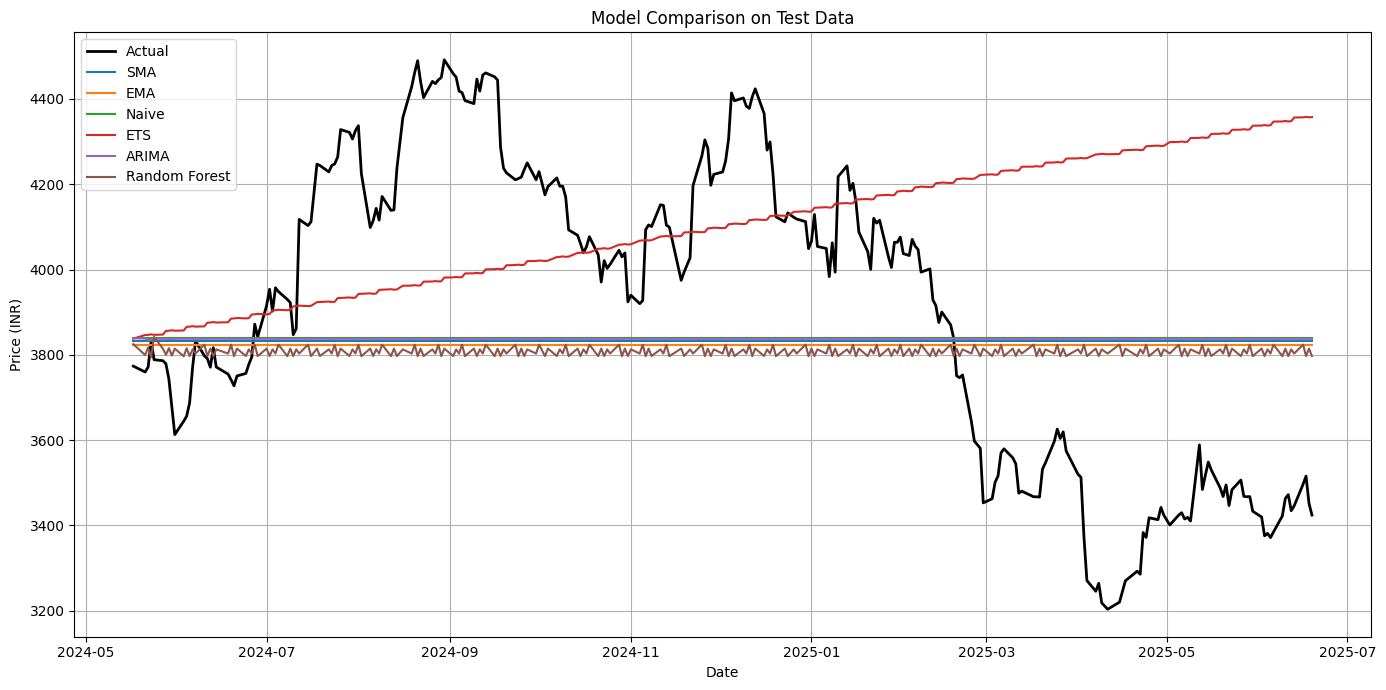

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from datetime import timedelta
import warnings

warnings.filterwarnings("ignore")

# --- Load stock data
df = yf.download("TCS.NS", start="2020-01-01", end="2025-06-20")[['Close']].dropna()
df.rename(columns={"Close": "y"}, inplace=True)

# --- Train-test split
split_index = int(len(df) * 0.8)
train, test = df.iloc[:split_index], df.iloc[split_index:]
test_dates = test.index

# --- SMA Forecast
sma_val = train['y'].rolling(10).mean().iloc[-1]
sma_forecast = pd.Series([sma_val] * len(test), index=test_dates)

# --- EMA Forecast
ema_val = train['y'].ewm(span=10, adjust=False).mean().iloc[-1]
ema_forecast = pd.Series([ema_val] * len(test), index=test_dates)

# --- Naive Forecast
naive_val = train['y'].iloc[-1]
naive_forecast = pd.Series([naive_val] * len(test), index=test_dates)

# --- ETS Forecast
ets_model = ExponentialSmoothing(train['y'], trend='add', seasonal='add', seasonal_periods=5)
ets_fit = ets_model.fit()
ets_forecast = ets_fit.forecast(len(test))
ets_forecast.index = test_dates

# --- ARIMA Forecast
arima_model = ARIMA(train['y'], order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))
arima_forecast.index = test_dates

# --- Random Forest Forecast
rf_train = train.copy()
rf_train['lag1'] = rf_train['y'].shift(1)
rf_train['lag2'] = rf_train['y'].shift(2)
rf_train.dropna(inplace=True)
X_rf = rf_train[['lag1', 'lag2']]
y_rf = rf_train['y']
model_rf = RandomForestRegressor()
model_rf.fit(X_rf, y_rf)

# Predict next len(test) days
last_lag1 = rf_train['lag1'].iloc[-1]
last_lag2 = rf_train['lag2'].iloc[-1]
rf_preds = []

for _ in range(len(test)):
    X_pred = np.array([[last_lag1, last_lag2]])
    pred = model_rf.predict(X_pred)[0]
    rf_preds.append(pred)
    last_lag2 = last_lag1
    last_lag1 = pred

rf_forecast = pd.Series(rf_preds, index=test_dates)

# --- Combine forecasts
results = pd.DataFrame({
    'Actual': test['y'].values.flatten(),
    'SMA': sma_forecast.values.flatten(),
    'EMA': ema_forecast.values.flatten(),
    'Naive': naive_forecast.values.flatten(),
    'ETS': ets_forecast.values.flatten(),
    'ARIMA': arima_forecast.values.flatten(),
    'Random Forest': rf_forecast.values.flatten()
}, index=test_dates)

# --- Calculate RMSE for each model
rmse_results = {}
for col in results.columns[1:]:
    rmse = np.sqrt(mean_squared_error(results['Actual'], results[col]))
    rmse_results[col] = rmse

# --- Display RMSE results
rmse_df = pd.DataFrame(list(rmse_results.items()), columns=["Model", "RMSE"]).sort_values(by="RMSE")
print("\n📊 Model RMSE Scores:")
print(rmse_df)

# --- Best model
best_model = rmse_df.iloc[0]
print(f"\n✅ Best fitted model: {best_model['Model']} with RMSE = {best_model['RMSE']:.2f}")

# --- Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(results['Actual'], label="Actual", color='black', linewidth=2)
for col in results.columns[1:]:
    plt.plot(results[col], label=col)
plt.title("Model Comparison on Test Data")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import pickle

# Save constant value forecasts as scalars
with open("model_sma.pkl", "wb") as f:
    pickle.dump(sma_val, f)

with open("model_ema.pkl", "wb") as f:
    pickle.dump(ema_val, f)

with open("model_naive.pkl", "wb") as f:
    pickle.dump(naive_val, f)

# Save trained models
with open("model_ets.pkl", "wb") as f:
    pickle.dump(ets_fit, f)

with open("model_arima.pkl", "wb") as f:
    pickle.dump(arima_fit, f)

with open("model_rf.pkl", "wb") as f:
    pickle.dump(model_rf, f)

print("\n✅ All models saved as .pkl files.")



✅ All models saved as .pkl files.


In [1]:
pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.
